<a href="https://colab.research.google.com/github/yfwang1217/cifar10-pytorch/blob/main/dl_final_lfw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/lfw-deepfunneled.zip -d /content/


Archive:  /content/lfw-deepfunneled.zip
replace /content/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip uninstall jax jaxlib -y
!pip install jax jaxlib

import shutil
from shutil import unpack_archive
from subprocess import check_output
import keras


Found existing installation: jax 0.4.28
Uninstalling jax-0.4.28:
  Successfully uninstalled jax-0.4.28
Found existing installation: jaxlib 0.4.28
Uninstalling jaxlib-0.4.28:
  Successfully uninstalled jaxlib-0.4.28
  Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
  Using cached jaxlib-0.4.28-cp310-cp310-manylinux2014_x86_64.whl (77.5 MB)


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output
# Import necessary libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path and file constants
DATASET_PATH = "lfw-deepfunneled"
CSV_FILES = {
    "lfw_allnames": "lfw_allnames.csv",
    "matchpairsDevTest": "matchpairsDevTest.csv",
    "matchpairsDevTrain": "matchpairsDevTrain.csv",
    "mismatchpairsDevTest": "mismatchpairsDevTest.csv",
    "mismatchpairsDevTrain": "mismatchpairsDevTrain.csv",
    "pairs": "pairs.csv",
    "people": "people.csv",
    "peopleDevTest": "peopleDevTest.csv",
    "peopleDevTrain": "peopleDevTrain.csv"
}

# Load data
def load_data(files):
    return {name: pd.read_csv(filepath) for name, filepath in files.items()}

data = load_data(CSV_FILES)

# Tidy and preprocess data
data['pairs'] = data['pairs'].rename(columns={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = data['pairs'][data['pairs']['name2'].isnull()].drop("name2", axis=1)
mismatched_pairs = data['pairs'][data['pairs']['name2'].notnull()]

# Remove null values from 'people'
data['people'] = data['people'][data['people'].name.notnull()]

# Summary and analysis of the dataset
def summarize_data(df):
    most_represented = df.iloc[df['images'].idxmax()]
    return {
        "total_celebrities": df.shape[0],
        "multi_image_celebs": sum(df.images > 1),
        "total_images": sum(df.images),
        "most_represented": most_represented['name'],
        "max_images": max(df.images)
    }

summary = summarize_data(data['lfw_allnames'])
print("Summary:")
print(f"There are {summary['total_celebrities']} unique celebrities in the entire dataset, of whom "
      f"{summary['multi_image_celebs']} are represented by multiple images. The entire number of images available is "
      f"{summary['total_images']}. The most represented celebrity is {summary['most_represented']}, with "
      f"{summary['max_images']} unique images in the dataset.")

# Prepare image paths
def generate_image_paths(df):
    image_paths = df.loc[df.index.repeat(df['images'])]
    image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
    image_paths['image_path'] = image_paths.image_path.apply(lambda x: f"{x:04}")
    image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths['image_path'] + ".jpg"
    return image_paths.drop("images", axis=1)

image_paths = generate_image_paths(data['lfw_allnames'])

# Split the data into train and test sets
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2, random_state=42)
lfw_train = lfw_train.reset_index(drop=True)
lfw_test = lfw_test.reset_index(drop=True)

# Print intersection and difference between train and test sets
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))


Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.
852
863


<Axes: xlabel='name'>

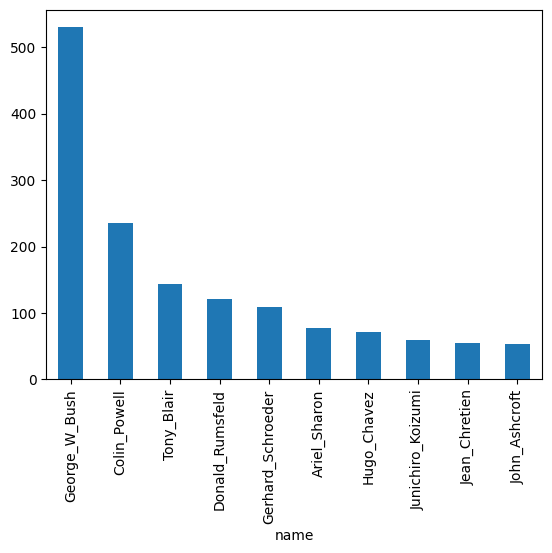

In [4]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Constants for names
TARGET_NAME = "George_W_Bush"
NEGATIVE_CLASS_NAME = "not_George"

# Filter out images of George W. Bush and sample the same number of images from other individuals
george_images = image_paths[image_paths.name == TARGET_NAME]
not_george_images = image_paths[image_paths.name != TARGET_NAME].sample(530)
not_george_images.name = NEGATIVE_CLASS_NAME

# Combine the two datasets into a single DataFrame
combined_data = pd.concat([george_images, not_george_images])

# Split the combined data into a training set and a hold-out test set
bush_train_test, bush_test = train_test_split(combined_data, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
bush_train, bush_val = train_test_split(bush_train_test, test_size=0.2, random_state=42)

# Print the sizes of the datasets to confirm splits
print(f"Training Set Size: {bush_train.shape[0]}")
print(f"Validation Set Size: {bush_val.shape[0]}")
print(f"Test Set Size: {bush_test.shape[0]}")


Training Set Size: 678
Validation Set Size: 170
Test Set Size: 212


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

Bush_classifier = Sequential()

# Use GlorotUniform (also known as Xavier initialization) for better convergence in deep networks
initializer = GlorotUniform()

# First convolutional block
Bush_classifier.add(Conv2D(16, (5, 5), input_shape=(250, 250, 3), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Second convolutional block
Bush_classifier.add(Conv2D(32, (4, 4), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Third convolutional block
Bush_classifier.add(Conv2D(48, (3, 3), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=True, bias_initializer='zeros'))
Bush_classifier.add(Activation('relu'))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))


# Output layer for binary classification
Bush_classifier.add(Flatten())

# Fully connected layer with 5000 units
Bush_classifier.add(Dense(units=5000, activation='relu'))


# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [14]:
import os
import shutil

def directory_mover(data, dir_name):
    base_path = '/content'
    target_dir = os.path.join(base_path, dir_name)
    source_dir = 'lfw-deepfunneled/lfw-deepfunneled'

    # Ensure the top directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    count = 0
    for image_path in data.image_path:
        person_name = data[data['image_path'] == image_path]['name'].iloc[0]
        person_dir = os.path.join(target_dir, person_name)

        # Ensure the person's directory exists
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # Construct full source and destination paths
        full_source_path = os.path.join(source_dir, image_path)
        full_destination_path = os.path.join(person_dir, os.path.basename(image_path))

        # Copy the image
        shutil.copy(full_source_path, full_destination_path)
        count += 1

    print(f'Moved {count} images to {dir_name} folder.')

# Move images to specified directories
directory_mover(bush_train, "Bush_train/")
directory_mover(bush_val, "Bush_val/")
directory_mover(bush_test, "Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [15]:

# define a custom function to move images to a new train/test/val directory
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set = train_datagen.flow_from_directory('Bush_train',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('Bush_val',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('Bush_test',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup data generators
Bush_training_set = train_datagen.flow_from_directory(
    'Bush_train',
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

Bush_val_set = test_datagen.flow_from_directory(
    'Bush_val',
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

# Determine correct steps per epoch
steps_per_epoch = len(Bush_training_set)
validation_steps = len(Bush_val_set)

# Train the model
Bush_history = Bush_classifier.fit(
    Bush_training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=Bush_val_set,
    validation_steps=validation_steps
)

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Epoch 1/20
22/22 [==============================] - 12s 428ms/step - loss: 1.2963 - accuracy: 0.5782 - val_loss: 0.6300 - val_accuracy: 0.6647
Epoch 2/20
22/22 [==============================] - 11s 503ms/step - loss: 0.5999 - accuracy: 0.6932 - val_loss: 0.6322 - val_accuracy: 0.7000
Epoch 3/20
22/22 [==============================] - 11s 504ms/step - loss: 0.5187 - accuracy: 0.7566 - val_loss: 0.6859 - val_accuracy: 0.6882
Epoch 4/20
22/22 [==============================] - 11s 472ms/step - loss: 0.5087 - accuracy: 0.7655 - val_loss: 0.6195 - val_accuracy: 0.7412
Epoch 5/20
22/22 [==============================] - 11s 505ms/step - loss: 0.4060 - accuracy: 0.8333 - val_loss: 0.6213 - val_accuracy: 0.7118
Epoch 6/20
22/22 [==============================] - 11s 510ms/step - loss: 0.384

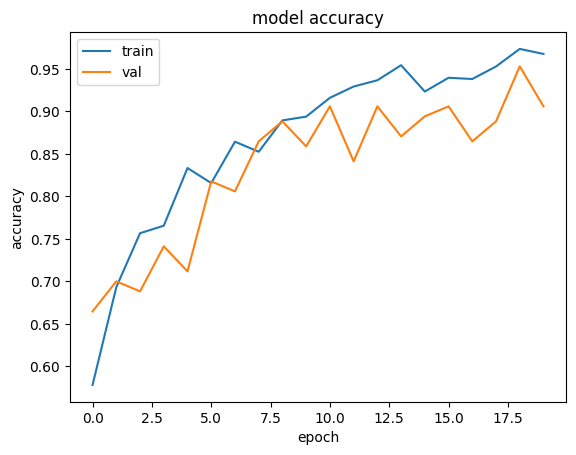

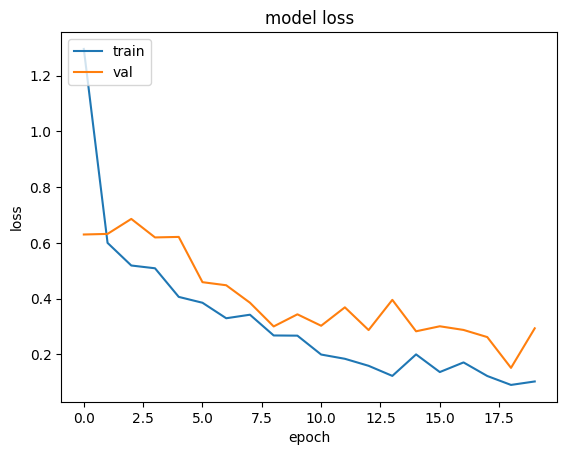

In [16]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
from keras.preprocessing import image

def load_and_predict_image(img_path, classifier, target_size=(250, 250), binary=True):
    """Load an image, preprocess, and make a prediction."""
    test_image = image.load_img(img_path, target_size=target_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = classifier.predict(test_image)
    return float(prediction[0]) if binary else np.argmax(prediction)

def predict_directory(directory, classifier, binary=True):
    """Predict all images in a directory."""
    predictions = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        result = load_and_predict_image(img_path, classifier, binary=binary)
        predictions.append(result)
    return predictions

def get_ordered_class_names(data_generator):
    """Extract ordered class names from the filenames in a data generator."""
    filenames = data_generator.filenames
    class_names = [fn.split("/")[0] for fn in filenames]
    ordered_class_names = list(OrderedDict.fromkeys(class_names))
    return ordered_class_names

def calculate_metrics(predictions_frame):
    """Calculate precision, accuracy, and recall from predictions."""
    metrics = {'precision': [], 'accuracy': [], 'recall': []}
    unique_preds = set(predictions_frame.Predictions)
    total_preds = len(predictions_frame)
    for i in unique_preds:
        tp = len(predictions_frame[(predictions_frame['Actual'] == i) & (predictions_frame['Predictions'] == i)])
        tn = len(predictions_frame[(predictions_frame['Actual'] != i) & (predictions_frame['Predictions'] != i)])
        fp = len(predictions_frame[(predictions_frame['Actual'] != i) & (predictions_frame['Predictions'] == i)])
        fn = len(predictions_frame[(predictions_frame['Actual'] == i) & (predictions_frame['Predictions'] != i)])
        metrics['precision'].append(tp / (tp + fp) if (tp + fp) else 0)
        metrics['accuracy'].append((tp + tn) / total_preds if total_preds else 0)
        metrics['recall'].append(tp / (tp + fn) if (tp + fn) else 0)
    return metrics

# Use the functions to process the test data
ordered_names = get_ordered_class_names(Bush_test_set)
predictions = []
for name in ordered_names:
    dir_path = os.path.join("Bush_test", name)
    predictions.extend(predict_directory(dir_path, Bush_classifier, binary=True))

# Actual classes setup
actuals = [0] * len(predictions[:len(predictions)//2]) + [1] * len(predictions[len(predictions)//2:])

# Compare predictions to actual classes
predictions_frame = pd.DataFrame(list(zip(predictions, actuals)), columns=['Predictions', 'Actual'])
metrics = calculate_metrics(predictions_frame)

print('Precision:', metrics['precision'])
print('Recall:', metrics['recall'])


1/1 [==============================] - 0s 26ms/step


<ipython-input-17-f7ad9a0a578e>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(prediction[0]) if binary else np.argmax(prediction)


1/1 [==============================] - 0s 18ms/step
Precision: [0.8091603053435115, 1.0, 0.0, 0.0, 0.0]
Recall: [1.0, 0.7358490566037735, 0, 0, 0]


In [18]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [19]:
# 保存模型
Bush_classifier.save('Bush_classifier.h5')

# 加载模型
from tensorflow.keras.models import load_model
model = load_model('Bush_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.initializers import GlorotUniform

# Define the model builders
def build_model_cnn_s(input_shape):
    model = Sequential([
        Conv2D(12, (5, 5), input_shape=input_shape, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_cnn_m(input_shape):
    model = Sequential([
        Conv2D(24, (4, 4), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_cnn_l(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(48, (3, 3), strides=(2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Image Data Generator Setup
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

def train_and_evaluate_model(model_builder, train_set, val_set, test_set):
    model = model_builder((250, 250, 3))
    history = model.fit(
        train_set,
        steps_per_epoch=len(train_set),
        epochs=20,
        validation_data=val_set,
        validation_steps=len(val_set)
    )
    test_loss, test_acc = model.evaluate(test_set)
    return history, test_loss, test_acc

# Load Data (assuming data is already prepared)
Bush_training_set = train_datagen.flow_from_directory('Bush_train/', target_size=(250, 250), batch_size=32, class_mode='binary')
Bush_val_set = test_datagen.flow_from_directory('Bush_val/', target_size=(250, 250), batch_size=32, class_mode='binary')
Bush_test_set = test_datagen.flow_from_directory('Bush_test/', target_size=(250, 250), batch_size=32, class_mode='binary')

models = [build_model_cnn_s, build_model_cnn_m, build_model_cnn_l]
results = {}
model_names = ['S', 'M', 'L']  # Correctly specify model names

for i, model_builder in enumerate(models):
    model_name = f"CNN-{model_names[i]}"  # Use predefined model names
    print(f"Training and evaluating model {model_name}")
    history, test_loss, test_acc = train_and_evaluate_model(model_builder, Bush_training_set, Bush_val_set, Bush_test_set)
    results[model_name] = (history, test_loss, test_acc)

# Display results
for key, value in results.items():
    print(f"{key} Test Accuracy: {value[2]}")
    plt.plot(value[0].history['accuracy'], label=f"{key} Train")
    plt.plot(value[0].history['val_accuracy'], label=f"{key} Val")
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Training and evaluating model CNN-S
Epoch 1/20
22/22 [==============================] - 13s 474ms/step - loss: 1.1462 - accuracy: 0.5590 - val_loss: 0.6719 - val_accuracy: 0.6059
Epoch 2/20
17/22 [======================>.......] - ETA: 2s - loss: 0.6128 - accuracy: 0.7059